<a href="https://colab.research.google.com/github/BhojRajBist/BhojRajBist/blob/main/District_and_Provience_wise_NCRF_forecast_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: add the base dir

Step 2 : Add the provience and district Shapefile


Generated TIFF URLs: ['https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072303F01O2024072300H003R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072306F02O2024072300H006R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072309F03O2024072300H009R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072312F04O2024072300H012R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072315F05O2024072300H015R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072318F06O2024072300H018R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072321F07O2024072300H021R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072400F08O2024072300H024R4KMC.

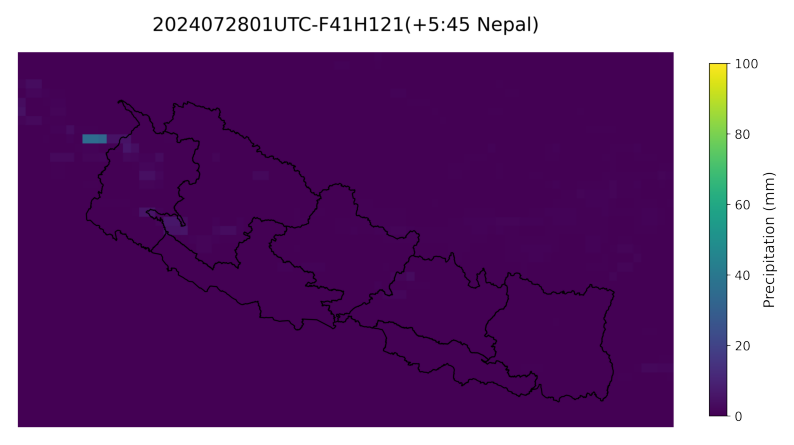

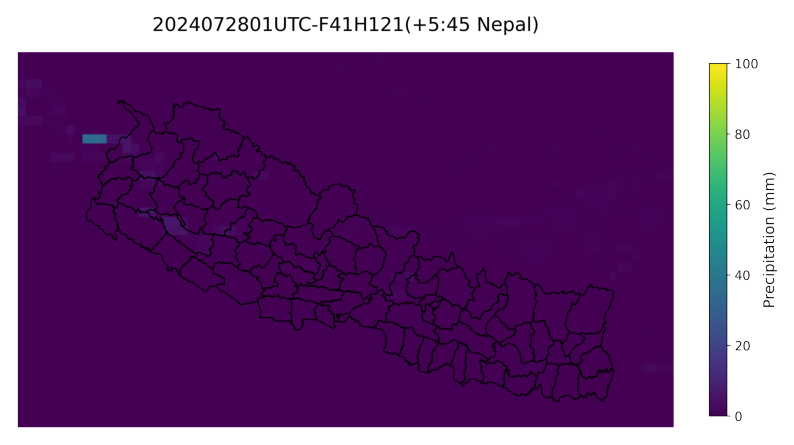

In [19]:
# Install the required libraries
!pip install rasterio pyproj pandas matplotlib imageio requests geopandas

import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import imageio
from IPython.display import HTML
import requests
import geopandas as gpd
from shapely.geometry import box
from matplotlib.animation import FuncAnimation

# Set root_dir to a fixed value
root_dir = "20240723"

# Create the frames directory
frames_dir = os.path.join(root_dir, "FRAMES")
os.makedirs(frames_dir, exist_ok=True)

# Define the base URI
uri_base = f"https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/{root_dir}/"

# Define the forecast origin date
forecast_origin_date = datetime.strptime(root_dir, "%Y%m%d")

# Function to pad numbers
def pad2(num):
    return str(num).zfill(2)

def pad3(num):
    return str(num).zfill(3)

# Generate the list of URIs
tiff_urls = []
for i in range(1, 42):
    if i <= 25:
        time_step_hours = i * 3
        file_suffix = 'R4KMC.tif'
    else:
        time_step_hours = i * 3 - 2
        file_suffix = 'R12.5KMC.tif'

    time_step_str = pad3(time_step_hours)
    forecast_hour_index = pad2(i)
    forecast_time = forecast_origin_date + timedelta(hours=time_step_hours)
    forecast_time_str = forecast_time.strftime('%Y%m%d%H')

    uri = f"{uri_base}NCMRWF_Nepal_{forecast_time_str}F{forecast_hour_index}O{root_dir}00H{time_step_str}{file_suffix}"
    tiff_urls.append(uri)

print("Generated TIFF URLs:", tiff_urls)

# Function to download and save TIFF files
def download_tiff_files(urls, download_dir):
    tiff_files = []
    for url in urls:
        filename = os.path.join(download_dir, os.path.basename(url))
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            tiff_files.append(filename)
        else:
            print(f"Failed to download {url}")
    return tiff_files

# Download the TIFF files
tiff_files = download_tiff_files(tiff_urls, root_dir)
print("Downloaded TIFF files:", tiff_files)

# Load the shapefiles
prov_shapefile_path = '/content/hermes_NPL_new_wgs_1.shp'
dist_shapefile_path = '/content/hermes_NPL_new_wgs_2.shp'

prov_gdf = gpd.read_file(prov_shapefile_path)
dist_gdf = gpd.read_file(dist_shapefile_path)

# Ensure the shapefiles are in the same coordinate reference system (CRS) as your data
prov_gdf = prov_gdf.to_crs(epsg=4326)
dist_gdf = dist_gdf.to_crs(epsg=4326)

# Function to plot precipitation data from TIFF files and save to PNG frames
def animate_precipitation_data_tiff_no_background(tiff_files, shapefile_gdf, shapefile_name, output_dir):
    for i, file_path in enumerate(tiff_files):
        with rasterio.open(file_path) as src:
            precipitation = src.read(1)
            bounds = src.bounds

            fig, ax = plt.subplots(figsize=(12, 8))
            im = ax.imshow(precipitation, cmap='viridis', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], vmin=0, vmax=100)
            ax.axis('off')  # Turn off the axis

            # Add title and colorbar
            filename = os.path.basename(file_path)
            parts = filename.split('_')
            timestamp = parts[2].split('F')[0]  # Extract timestamp
            forecastIndex = parts[2].split('F')[1].split('O')[0]  # Extract forecast index
            forecastHrsPart = parts[2].split('H')[1]  # Extract forecast hours part
            forecastHrs = forecastHrsPart.split('R')[0]  # Extract forecast hours
            title = timestamp + 'UTC-F' + forecastIndex + 'H' + forecastHrs + '(+5:45 Nepal)'

            # Add a background to the title
            plt.title(title, fontsize=18, pad=20, backgroundcolor='white')

            norm = mcolors.Normalize(vmin=0, vmax=100)
            cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.05, fraction=0.025, norm=norm)
            cbar.set_label('Precipitation (mm)', fontsize=14)
            cbar.ax.yaxis.set_tick_params(labelsize=12)  # Adjust font size of color bar values

            # Plot the shapefile on top of the precipitation data
            ax.set_ylim(bounds.top, bounds.bottom)
            shapefile_gdf.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=1)

            # Save each frame with transparent background
            frame_filename = os.path.join(output_dir, f'frame_{i:04d}.png')
            plt.savefig(frame_filename, bbox_inches='tight', dpi=400, transparent=True)
            plt.close(fig)

    print("Frames saved successfully.")

    # Create an animated GIF from the frames with a delay between frames
    frame_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')])
    gif_filename = os.path.join(output_dir, f'precipitation_animation_{shapefile_name}.gif')
    with imageio.get_writer(gif_filename, mode='I', duration=1) as writer:  # 1-second delay
        for frame_file in frame_files:
            image = imageio.v2.imread(frame_file)
            writer.append_data(image)

    print(f"Animation saved as {gif_filename}.")

    # Function to update each frame
    def update(frame):
        im.set_data(plt.imread(frame_files[frame]))
        return im,

    # Create a figure without the outer frame
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')  # Turn off the axis

    # Display the first frame
    im = ax.imshow(plt.imread(frame_files[0]))

    # Create the animation with the specified interval
    ani = FuncAnimation(fig, update, frames=len(frame_files), interval=1000)

    # Display the animation
    return HTML(ani.to_html5_video())

# Call the function to plot precipitation data for provinces
prov_frames_dir = os.path.join(root_dir, "provinces_frames")
os.makedirs(prov_frames_dir, exist_ok=True)
animate_precipitation_data_tiff_no_background(tiff_files, prov_gdf, 'provinces', prov_frames_dir)

# Call the function to plot precipitation data for districts
dist_frames_dir = os.path.join(root_dir, "districts_frames")
os.makedirs(dist_frames_dir, exist_ok=True)
animate_precipitation_data_tiff_no_background(tiff_files, dist_gdf, 'districts', dist_frames_dir)


Add the shapefiles of district and provience


In [3]:
import requests
import os

# Set root_dir to a fixed value
root_dir = "20240723"

# Define the base URI
uri_base = f"https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/{root_dir}/"

# Define the forecast origin date
forecast_origin_date = datetime.strptime(root_dir, "%Y%m%d")

# Function to pad numbers
def pad2(num):
    return str(num).zfill(2)

def pad3(num):
    return str(num).zfill(3)

# Generate the list of URIs
tiff_urls = []
for i in range(1, 42):
    if i <= 25:
        time_step_hours = i * 3
        file_suffix = 'R4KMC.tif'
    else:
        time_step_hours = i * 3 - 2
        file_suffix = 'R12.5KMC.tif'

    time_step_str = pad3(time_step_hours)
    forecast_hour_index = pad2(i)
    forecast_time = forecast_origin_date + timedelta(hours=time_step_hours)
    forecast_time_str = forecast_time.strftime('%Y%m%d%H')

    uri = f"{uri_base}NCMRWF_Nepal_{forecast_time_str}F{forecast_hour_index}O{root_dir}00H{time_step_str}{file_suffix}"
    tiff_urls.append(uri)

print("Generated TIFF URLs:", tiff_urls)

# Function to download and save TIFF files
def download_tiff_files(urls, download_dir):
    tiff_files = []
    for url in urls:
        filename = os.path.join(download_dir, os.path.basename(url))
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            tiff_files.append(filename)
        else:
            print(f"Failed to download {url}")
    return tiff_files

# Create directory and download TIFF files
os.makedirs(root_dir, exist_ok=True)
tiff_files = download_tiff_files(tiff_urls, root_dir)
print("Downloaded TIFF files:", tiff_files)


Generated TIFF URLs: ['https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072303F01O2024072300H003R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072306F02O2024072300H006R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072309F03O2024072300H009R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072312F04O2024072300H012R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072315F05O2024072300H015R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072318F06O2024072300H018R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072321F07O2024072300H021R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240723/NCMRWF_Nepal_2024072400F08O2024072300H024R4KMC.

Commented code will generate vertical frames

In [ ]:
# from PIL import Image
# import geopandas as gpd
# import rasterio
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import os

# # Function to create composite image
# def create_composite_image_for_duration(tiff_files, duration_hours, output_dir, shapefile_gdf, shapefile_name):
#     # Filter TIFF files by duration
#     def filter_tiff_files_by_duration(files, duration_hours):
#         filtered_files = []
#         total_hours = 0
#         for file in files:
#             if total_hours >= duration_hours:
#                 break
#             filtered_files.append(file)
#             total_hours += 3  # Assuming each file represents a 3-hour increment
#         return filtered_files

#     filtered_files = filter_tiff_files_by_duration(tiff_files, duration_hours)

#     if not filtered_files:
#         print(f"No TIFF files found for {duration_hours} hours.")
#         return

#     # Create a directory for the duration
#     duration_dir = os.path.join(output_dir, f"{duration_hours}_hours")
#     os.makedirs(duration_dir, exist_ok=True)

#     # Plot and save each frame
#     for i, file_path in enumerate(filtered_files):
#         with rasterio.open(file_path) as src:
#             precipitation = src.read(1)
#             bounds = src.bounds

#             fig, ax = plt.subplots(figsize=(12, 8))
#             im = ax.imshow(precipitation, cmap='viridis', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], vmin=0, vmax=100)
#             ax.axis('off')  # Turn off the axis

#             # Invert y-axis if needed
#             ax.invert_yaxis()

#             # Add title and colorbar
#             filename = os.path.basename(file_path)
#             title = f"{filename} (+5:45 Nepal)"
#             plt.title(title, fontsize=18, pad=20, backgroundcolor='white')

#             norm = mcolors.Normalize(vmin=0, vmax=100)
#             cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.05, fraction=0.025, norm=norm)
#             cbar.set_label('Precipitation (mm)', fontsize=14)
#             cbar.ax.yaxis.set_tick_params(labelsize=12)  # Adjust font size of color bar values

#             # Plot the shapefile on top of the precipitation data
#             shapefile_gdf.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=1)

#             # Save each frame with transparent background
#             frame_filename = os.path.join(duration_dir, f'frame_{i:04d}.png')
#             plt.savefig(frame_filename, bbox_inches='tight', dpi=400, transparent=True)
#             plt.close(fig)

#     print(f"Frames for {duration_hours} hours saved successfully.")

#     # Merge all frames into one composite image
#     frame_files = sorted([os.path.join(duration_dir, f) for f in os.listdir(duration_dir) if f.endswith('.png')])
#     if not frame_files:
#         print(f"No frames found for {duration_hours} hours.")
#         return

#     images = [Image.open(frame_file) for frame_file in frame_files]
#     total_width = max(im.width for im in images)
#     total_height = sum(im.height for im in images)

#     composite_image = Image.new('RGBA', (total_width, total_height))
#     y_offset = 0
#     for im in images:
#         composite_image.paste(im, (0, y_offset))
#         y_offset += im.height

#     composite_image_path = os.path.join(output_dir, f"composite_{duration_hours}_hours_{shapefile_name}.png")
#     composite_image.save(composite_image_path)
#     print(f"Composite image for {duration_hours} hours saved as {composite_image_path}.")

# # Paths
# prov_shapefile_path = '/content/hermes_NPL_new_wgs_1.shp'
# dist_shapefile_path = '/content/hermes_NPL_new_wgs_2.shp'

# # Load shapefiles
# prov_gdf = gpd.read_file(prov_shapefile_path).to_crs(epsg=4326)
# dist_gdf = gpd.read_file(dist_shapefile_path).to_crs(epsg=4326)

# # Example usage for different durations
# create_composite_image_for_duration(tiff_files, 24, root_dir, prov_gdf, 'provinces')
# create_composite_image_for_duration(tiff_files, 24, root_dir, dist_gdf, 'districts')

# create_composite_image_for_duration(tiff_files, 72, root_dir, prov_gdf, 'provinces')
# create_composite_image_for_duration(tiff_files, 72, root_dir, dist_gdf, 'districts')

# create_composite_image_for_duration(tiff_files, 120, root_dir, prov_gdf, 'provinces')
# create_composite_image_for_duration(tiff_files, 120, root_dir, dist_gdf, 'districts')
from PIL import Image
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# Function to create composite image
def create_composite_image_for_duration(tiff_files, duration_hours, output_dir, shapefile_gdf, shapefile_name):
    # Filter TIFF files by duration
    def filter_tiff_files_by_duration(files, duration_hours):
        filtered_files = []
        total_hours = 0
        for file in files:
            if total_hours >= duration_hours:
                break
            filtered_files.append(file)
            total_hours += 3  # Assuming each file represents a 3-hour increment
        return filtered_files

    filtered_files = filter_tiff_files_by_duration(tiff_files, duration_hours)

    if not filtered_files:
        print(f"No TIFF files found for {duration_hours} hours.")
        return

    # Create a directory for the duration
    duration_dir = os.path.join(output_dir, f"{duration_hours}_hours")
    os.makedirs(duration_dir, exist_ok=True)

    # Plot and save each frame
    for i, file_path in enumerate(filtered_files):
        with rasterio.open(file_path) as src:
            precipitation = src.read(1)
            bounds = src.bounds

            fig, ax = plt.subplots(figsize=(12, 8))
            im = ax.imshow(precipitation, cmap='viridis', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], vmin=0, vmax=100)
            ax.axis('off')  # Turn off the axis

            # Invert y-axis if needed
            ax.invert_yaxis()

            # Add title and colorbar
            filename = os.path.basename(file_path)
            title = f"{filename} (+5:45 Nepal)"
            plt.title(title, fontsize=18, pad=20, backgroundcolor='white')

            norm = mcolors.Normalize(vmin=0, vmax=100)
            cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.05, fraction=0.025, norm=norm)
            cbar.set_label('Precipitation (mm)', fontsize=14)
            cbar.ax.yaxis.set_tick_params(labelsize=12)  # Adjust font size of color bar values

            # Plot the shapefile on top of the precipitation data
            shapefile_gdf.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=1)

            # Save each frame with transparent background
            frame_filename = os.path.join(duration_dir, f'frame_{i:04d}.png')
            plt.savefig(frame_filename, bbox_inches='tight', dpi=400, transparent=True)
            plt.close(fig)

    print(f"Frames for {duration_hours} hours saved successfully.")

    # Merge all frames into one composite image
    frame_files = sorted([os.path.join(duration_dir, f) for f in os.listdir(duration_dir) if f.endswith('.png')])
    if not frame_files:
        print(f"No frames found for {duration_hours} hours.")
        return

    images = [Image.open(frame_file) for frame_file in frame_files]

    # Calculate size for the composite image
    frame_width, frame_height = images[0].size
    images_per_row = 2
    num_rows = (len(images) + images_per_row - 1) // images_per_row  # Calculate number of rows needed

    total_width = images_per_row * frame_width
    total_height = num_rows * frame_height

    composite_image = Image.new('RGBA', (total_width, total_height))

    # Paste images into the composite image
    for index, im in enumerate(images):
        row = index // images_per_row
        col = index % images_per_row
        x_offset = col * frame_width
        y_offset = row * frame_height
        composite_image.paste(im, (x_offset, y_offset))

    composite_image_path = os.path.join(output_dir, f"composite_{duration_hours}_hours_{shapefile_name}.png")
    composite_image.save(composite_image_path)
    print(f"Composite image for {duration_hours} hours saved as {composite_image_path}.")

# Paths
prov_shapefile_path = '/content/hermes_NPL_new_wgs_1.shp'
dist_shapefile_path = '/content/hermes_NPL_new_wgs_2.shp'

# Load shapefiles
prov_gdf = gpd.read_file(prov_shapefile_path).to_crs(epsg=4326)
dist_gdf = gpd.read_file(dist_shapefile_path).to_crs(epsg=4326)

# Example usage for different durations
create_composite_image_for_duration(tiff_files, 24, root_dir, prov_gdf, 'provinces')
create_composite_image_for_duration(tiff_files, 24, root_dir, dist_gdf, 'districts')

create_composite_image_for_duration(tiff_files, 72, root_dir, prov_gdf, 'provinces')
create_composite_image_for_duration(tiff_files, 72, root_dir, dist_gdf, 'districts')

create_composite_image_for_duration(tiff_files, 120, root_dir, prov_gdf, 'provinces')
create_composite_image_for_duration(tiff_files, 120, root_dir, dist_gdf, 'districts')


Frames for 24 hours saved successfully.
Composite image for 24 hours saved as 20240723/composite_24_hours_provinces.png.
Frames for 24 hours saved successfully.
Composite image for 24 hours saved as 20240723/composite_24_hours_districts.png.
Frames for 72 hours saved successfully.
Composite image for 72 hours saved as 20240723/composite_72_hours_provinces.png.
Frames for 72 hours saved successfully.
Composite image for 72 hours saved as 20240723/composite_72_hours_districts.png.
Frames for 120 hours saved successfully.
Composite image for 120 hours saved as 20240723/composite_120_hours_provinces.png.
